# 개요

- 기본적인 GAN 구현

# 모듈 가져오기

In [12]:
import tensorflow as tf

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# 손글씨 이미지 생성 -> 목표, 이 이미지가 가짜임을 잘 분별해 내는것도 -> 목표
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# 환경변수

In [15]:
# 이미지 정보
IMG_ROWS = 28   # h
IMG_COLS = 28   # w
IN_CHANNELS = 1 # 입력 이미지의 채널수
# 입력 이미지 data format : NHWC
# 입력 이미지 형태
IMG_SHAPE   = ( IMG_ROWS, IMG_COLS, IN_CHANNELS )
# 생성기(generator)에 들어가는 노이즈 백터 z의 크기 
Z_DIM       = 100 # 설정값

# 네트워크 구조

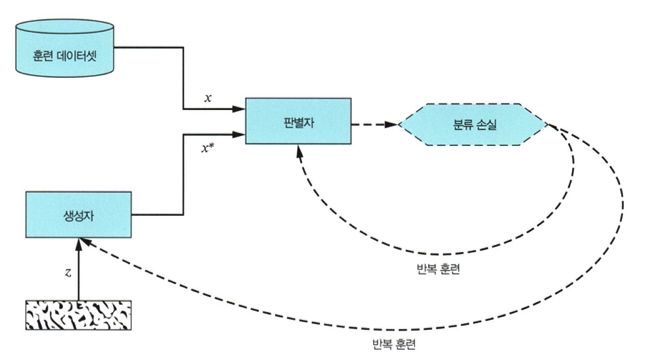

In [16]:
from IPython.display import Image
Image('/content/drive/MyDrive/edu.kenshi/2021/품질재단/DL/new_res/GAN-5.png')

# 생성자 (Generator)

- z 백터를 입력받서, x*를 출력 
- x*는 IMG_SHAPE:(28,28,1)의 형태를 이미지이다

In [17]:
def build_generator( z_dim,  img_shape ):
  '''
    생성자
    z(100,) -> (128,) -> 활성화함수 -> (28*28*1)  ->(28,28,1)
    훈련을 통해서 결국 0 ~ 9라는 손글씨 이미지를 거의 원본에 가깝게 만들어 낼 것이다
    그렇게 파라미터들이 훈련될 것이다
  '''
  # 시퀀셜 생성
  model = Sequential()
  # 784 <-              <- 증폭    <-     증폭    <- 얼마큼
  # z(100,) -> (128,) -> 활성화함수 -> (28*28*1)  ->(28,28,1)
  model.add( Dense( 128, input_dim=z_dim)  )
  # 활성화함수
  # LeakyReLU -> ReLU에서 음수쪽에 기울기를 0.01을 넣어서 완만하게 0에 수렴하도록 relu를 개선
  # 죽은뉴런 문제 -> 기울기를 부여하여 학습이 유지되고 훈련결과를 높이는데 향상
  model.add( LeakyReLU(0.01) )
  # 최종 이미지의 shape 형태의 개수만큼 증가 -> tanh
  # tanh : -1 ~ 1 사이로 값을 출력값을 조절 -> sigmod 보다 뚜렷한 이미지를 만드는 장점
  model.add( Dense( IMG_ROWS*IMG_COLS*IN_CHANNELS, activation='tanh' )  )
  # 입력 이미지 크기 
  model.add( Reshape( img_shape ) )
  # 생성기 모델을 리턴
  return model
  #pass

# 판별자 (discriminator)

- x와 x*를 입력받아, 진짜, 가짜를 판별
  - 가짜와 진짜를 구별해는 확률
- x, x*는 IMG_SHAPE:(28,28,1)의 형태를 가진다

In [18]:
def build_discriminator( img_shape ):
  '''
    판별자
    (28,28,1) => (28*28*1,)  => (128,)  => LeakyReLU  => 진짜 or 가짜 sigmoid(0 ~ 1)
    생성자에서 만든 네트워크의 shape읋 변화를 반대로 적용해서 구성 -> 설정
    네트워크를 어떻게 만드는가는 만들기 나름
    ex) 판별자의 네트워크를 CNN 으로 구성하면 DCGAN이된다 
    진짜와 가짜를 잘 구분해 낼것이다-> 이렇게 훈련받고 파라미터들이 조정될것이다
  '''  
  model = Sequential()
  # 3D -> 1D :  (28,28,1) => (28*28*1,)
  model.add( Flatten( input_shape=img_shape ) )
  # (28*28*1,)  => (128,)
  model.add( Dense(128) )
  # (128,)  => LeakyReLU
  model.add( LeakyReLU( alpha=0.01 ) )
  # LeakyReLU  => 진짜 or 가짜 sigmod(0 ~ 1)
  model.add( Dense( 1, activation='sigmoid' ) )
  return model
  #pass

# Simple (or Basic) GAN

- 네트워크 구성 (생성자, 판별자 연결)
- 컴파일 (훈련할 준비가 되어 있다)

In [19]:
def build_GAN( generator, discrminator ):
  '''
    simple(or basic) gan
    생성자와 판별자 모델을 연결
    결합된 생성기 판별기 모델 ( Combined generator, discrminator model )
  '''
  model = Sequential()
  # 생성자 추가
  model.add( generator )
  # 판별자 추가  
  model.add( discrminator )
  return model
  #pass

# 빌드및 컴파일

In [20]:
# 생성자 빌드 -> 생성만 하면됨 -> 피드백은 전체 gan에서 받으면된다
generator    = build_generator( Z_DIM, IMG_SHAPE )

# 판별자 빌드 -> 판독-> 정확도 측정 -> 자체적인 피드백, gan에 피드백 받아야 된다
discrminator = build_discriminator( IMG_SHAPE )
# 판별자 컴파일 -> 정확도 판단
# binary_crossentropy : 이진 분류 (0 or 1) 분류(진짜, 가짜)
# Adam = SGD + Momentom => 가장 뛰어난 성능을 내고 있다 => 최적화 도구
discrminator.compile(metrics=['accuracy'] , optimizer=Adam(), loss='binary_crossentropy')

# 판별자 훈련 관련내용
# generator 훈련을 위해서, discrminator의 매개변수를 일정하게 유지할 필요가 있다
# 생성자 훈련을 위해서는 판별자의 파라미터를 동결처리해야한다
# 판별의 무게중심이 아니라, 훼이트에 무게 중심이 있다
# 원하는 결과에 따라 이 코드는 누락, 추가하거나 가능
# 전이학습을 통해서 특정 네트워크 부분을 학습하지 않게, 진행하게 처리할수 있다!!
discrminator.trainable = False

# GAN 빌드
gan          = build_GAN( generator, discrminator )
# GAN 컴파일
gan.compile(optimizer=Adam(), loss='binary_crossentropy')

# 훈련

- 생성된 이미지를 출력
  - 학습 중간에 출력하는 형태
  - 생성자가 학습이 진행될수록 점전더 진짜에 가깝에 이미지를 생성하고 있는지를 피드백
- 잡음 백터의 생성물이 -> 먼지같은 형태 -> 숫자로 진화
  - np.random.normal( 0, 1, (데이터개수(batch_size), 100) )
    - 평균 0, 표준편차 1이 되는 데이터의 분포를 가진 랜덤수를 만들어서, 주어진 shape에맞춰 배열을 생성하시오
    - 준정규분포

## 훈련

In [26]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()
X_train.shape

11501568/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [28]:
255.0/2

127.5

In [ ]:
# 0 ~ 255
X_train[0]
# -1.0 ~ 1.0으로 rescale 하시오 => tanh 활성화함수의 출력값에 맞춰서 스케일링
# 0 ~ 255 => -1.0 ~ 1.0 로 미리 변환한다  => 0 ~ 2
# 2분 실습
# 0 ~ 255 => 0 ~ 1
# X_train/ (255.0/2)
# 0 ~ 2
X_train/127.5 - 1.0

In [31]:
# 손실, 정확도, 훈련횟수 저장 리스트
losses = list()
acces = list()
iterations = list()

# 훈련 함수
def train( iters, batch_size, sInterval ):
  '''
    랜덤한 MNIST 이미지를 입력 받는다(진짜이미지)
    랜덤한 잡음 백터(z)로부터 가짜 이미지를 생성하여 입력 받는다.
    이 데이터를 가지고 판별자가 진짜인지 가짜인지를 판별하겠금 학습하는 함수이다
    단, 여기서는 판별자 네트워크를 고정한째(훈련시키지지않고) 생성자만 강화시키겠끔 훈련을 해보겟다
    이 과정을 반복. (시간 관계상 판별자는 고정하고 진행)
  '''
  # 1. 데이터 준비 => 판별자 : x, x*(훈련중 산출물), 생성자 : z(훈련중 생성)
  # 1-1. 진짜 데이터 로드
  (X_train, y_train),(X_test, y_test) = mnist.load_data()
  # tanh 활성화함수 대비하여 데이터 표현을 더 많기 하기 위해 rescale 처리
  # -1.0 ~ 1.0
  X_train = X_train/(255./2) - 1.0
  # X_train : (60000, 28, 28) => (60000, 28, 28, 1)
  X_train = np.expand_dims( X_train, axis=3 )
  # 판별값  batch_size 만큼 준비
  # 진짜 1(True), 가짜 0(False)
  real = np.ones(  (batch_size, 1) )
  fake = np.zeros( (batch_size, 1) )

  # 2. 반복 훈련 -> (내시) 균형에 도달했을때, 거의 불가능에 가깝다 -> 중간 생성물을 보고 판단한다.
  for iter in range( iters ):
    # 여기서는 가짜 이미지가 거의 진짜처럼 보이게 하는 결과에 방점
    # 2-1. 판별자 훈련 ---------------------------------------------------------
    # 실제 데이터 -> 128개 획득 - batch_size와 동일하게
    # 전체 샘플 60000개에서 랜덤으로 128개 를 선택받고
    indexs = np.random.randint( 0, X_train.shape[0], batch_size )
    imgs   = X_train[ indexs ]
    # z 백터 -> 생성자 -> 훼이크 데이터
    z         = np.random.normal( 0, 1, (batch_size, Z_DIM) )
    fake_imgs = generator.predict( z )
    # 판별기 훈련 => 가중치는 변동되지 않는다 => 파라미터 고정(설정)
    # 2-1-1. 진짜 데이터 훈련 -> imgs -> real
    d_loss_acc_real = discrminator.train_on_batch( imgs, real )
    # 2-1-2. 가짜 데이터 훈련 -> fake_imgs -> fake
    d_loss_acc_fake= discrminator.train_on_batch( fake_imgs, fake )
    # 2의 결과를 더해서 50%(0.5)를 취한다 => 평균
    # 변경 될것이다 -> 생성자는 GAN 훈련으로 인해 진화할것이기 때문에
    d_loss, d_accuracy = np.add( d_loss_acc_real,  d_loss_acc_fake) * 0.5


    # 2-2. 생성자 훈련 ---------------------------------------------------------
    # 2-2-1. z 백터 생성 -> ( 128, 100 )
    z         = np.random.normal( 0, 1, (batch_size, Z_DIM) )
    # 2-2-2. 제너레이터가 예측하는 결과물 => 가짜 이미지
    #        제너레이터의 미세조종은 판별자가 판별한후 그 결과를 받아서 조정된다    
    fake_imgs = generator.predict( z )
    # 2-3. GAN이 처리 ----------------------------------------------------------
    # GAN 훈련 -> 미세조정 -> 판별자(여기서는 영향을 않받는다,False), 생성자 
    # Generator 훈련이라고 표현해도 된다 -> 가짜 데이터가 진짜이다 
    # 입력 데이터에 따라 훈련하고, 그에 따른 가중치를 명시적으로 업데이트 하는 훈련 방법
    # 에포크 X, iteration 스타일로 총 회수로 관리할때 많이 사용되는 훈련 방법
    # fit, fit_generator, train_on_batch : keras 훈련 함수
    # 입력 = z 백터
    # 출력 = 정답(모든 구성원이 1인 백터)
    g_loss = gan.train_on_batch( x=z, y=real )

    # 2-3. 중간점검-현재까지훈련된생성자를 이용하여 이미지 생성 ----------------
    if (iter+1) % sInterval == 0: #0번째도 보길 원하면 iter, 1000번 째부터 보고 싶으면 iter+1
      # 손실 저장
      losses.append( (d_loss, g_loss) )
      # 정확도 저장 -> %표시
      acces.append( d_accuracy * 100.0 )
      # 훈련횟수 저장
      iterations.append( iter+1 )
      print( f'[{iter+1}] d_loss:{ d_loss } , g_loss:{ g_loss }, d_accuracy:{ d_accuracy }' )
      # ---
      # d_loss->높아져한다, g_loss-> 작아져야한다, d_accuracy-> 낮아진다
      # ---
      # 현재까지 훈련된 생성자로 만든 이미지를 그려라
      displayImg( generator )
      pass # if pass
    pass # for pass
  pass # func pass

## 중간 생성물 출력

In [30]:
# 중간 생성물을 출력 함수 -> 화면에 그리기
# generator에 z백터를 넣으면 0 ~ 9 까지 손글씨 이미지가 생성된다
def displayImg( generator ):
  '''
    아래 처림 총 20회를 그릴것이다
    [ 그림 ] [ 그림 ] [ 그림 ] [ 그림 ] <- 10000단위에서 그리는 양
    [ 그림 ] [ 그림 ] [ 그림 ] [ 그림 ] 
    [ 그림 ] [ 그림 ] [ 그림 ] [ 그림 ] 
    [ 그림 ] [ 그림 ] [ 그림 ] [ 그림 ] 
    잡음 백터 ( 4*4. z_dim ) -> 이것을 기초로 훼이트 이미지를 생성 그릴것이다
  '''
  # 1. 잡음 백터 준비
  image_rows = 4
  image_cols = 4
  z          = np.random.normal( 0, 1, ( image_rows*image_cols, Z_DIM ) )
  
  # 2. 현재 시점까지 파라미터가 갱신된 생성자를 통해서 fake 이미지 생성
  fake_imgs  = generator.predict( z )  

  # 3. 이미지를 그리기 위해서 데이터을 원복
  # 0~255 => -1 ~ 1 => 입력 => fake => -1 ~ 1 => 0 ~ 1 => 0 ~ 255 
  # -1 ~ 1 => *0.5 => -0.5 ~ 0.5 =>  +0.5 => 0 ~ 1
  # 이미지를 정확하게 그리기 위해서 값을 원본했다 => rescale image
  fake_imgs = ( fake_imgs*0.5 ) + 0.5
  # (   )
  
  # 4. 화면에 그려라 -> 1개의 차트에 16개의 그림이 들어가야 한다
  fig, axs = plt.subplots( nrows=image_rows, ncols=image_cols, sharex=True, sharey=True, figsize=(4,4) )
  
  fIndex = 0
  for i in range( image_rows ):
    for j in range( image_cols ):
      # 그리기 fake_imgs => ( image_rows*image_cols, 28, 28, 1)
      axs[ i,j ].imshow( fake_imgs[ fIndex, : , : , 0 ], cmap='gray' )
      axs[ i,j ].axis('off')
      fIndex += 1
  pass

## 훈련 시작 처리

[1000] d_loss:0.08317087404429913 , g_loss:3.181548595428467, d_accuracy:0.9921875
[2000] d_loss:0.019000930711627007 , g_loss:5.383335113525391, d_accuracy:0.9921875
[3000] d_loss:0.03749070595949888 , g_loss:5.953266620635986, d_accuracy:0.984375
[4000] d_loss:0.21139629930257797 , g_loss:4.9214558601379395, d_accuracy:0.90625
[5000] d_loss:0.20854425430297852 , g_loss:4.064205169677734, d_accuracy:0.91015625
[6000] d_loss:0.45749346911907196 , g_loss:3.6132102012634277, d_accuracy:0.78515625
[7000] d_loss:0.17924655973911285 , g_loss:4.537270545959473, d_accuracy:0.92578125
[8000] d_loss:0.39876866340637207 , g_loss:3.2832441329956055, d_accuracy:0.84375
[9000] d_loss:0.2839478999376297 , g_loss:3.585663318634033, d_accuracy:0.8828125
[10000] d_loss:0.17401758581399918 , g_loss:4.610783576965332, d_accuracy:0.94140625
[11000] d_loss:0.46652771532535553 , g_loss:2.644347667694092, d_accuracy:0.81640625
[12000] d_loss:0.18438537418842316 , g_loss:3.8740148544311523, d_accuracy:0.93359

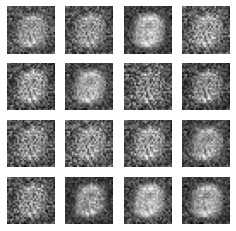

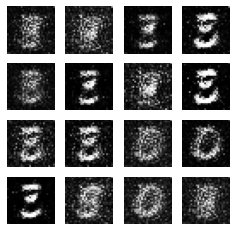

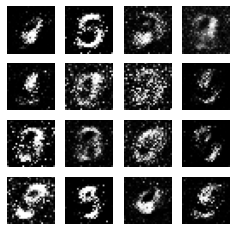

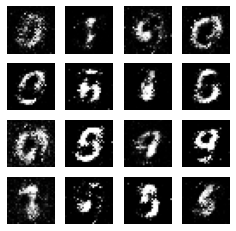

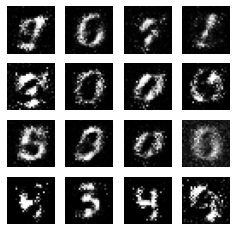

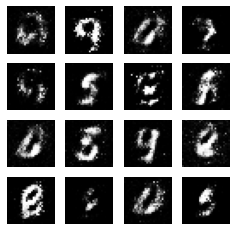

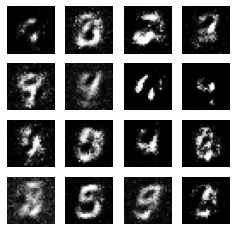

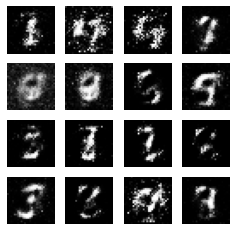

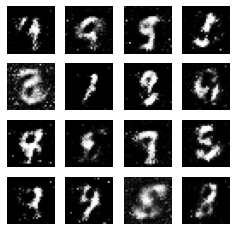

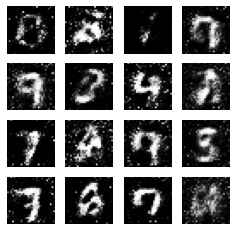

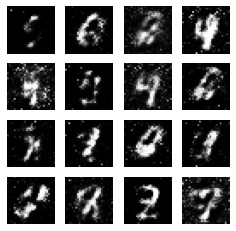

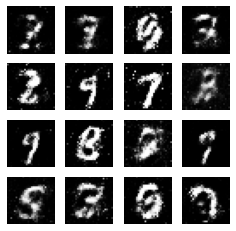

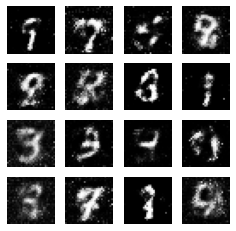

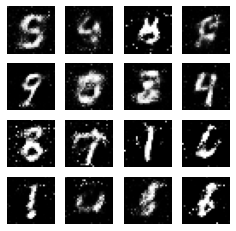

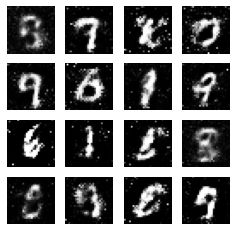

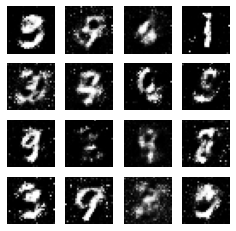

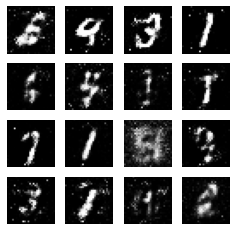

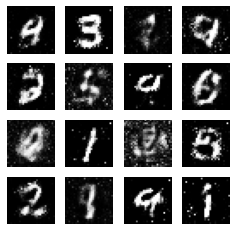

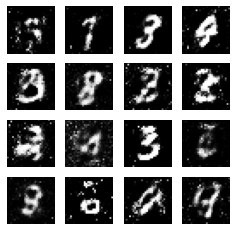

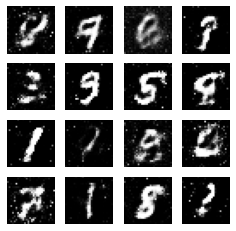

In [32]:
# 훈련 시작
'''
  - 미니 배치 학습 수행시
  - 메모리(CPU or GPU)가 커버할 양을 사용
  - 2의 배수 추천( 32, 64, 128. 256, ...) 사용
  - GAN은 훈련시 많은 컴퓨팅 시간이 필요하다
'''

# 훈련에 관련된 환경변수
# 총회수
iteration       = 20000 # 설정
# 1회 학습시 사용량 -> z백터 생성시 개수와 일치
batch_size      = 128   # 설정
# 몇번째 훈련에 도달하면 샘픔을 출력할 것이다
sample_interval = 1000  # 설정

# 훈련
train( iteration, batch_size, sample_interval )